# Explore the one_month_forecast_predict_delta_norm_y_latlons

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

In [4]:
EXPERIMENT =      '../features_/one_month_forecast_predict_delta_norm_y_latlons'
TRUE_EXPERIMENT = '../features_/one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TARGET_VAR =      'boku_VCI'  # 'VCI3M'  # 'boku_VCI'

# experiment = 'one_month_forecast_predict_delta_norm_y_latlons'
# true_data_experiment = 'one_month_forecast'


# Read in the data

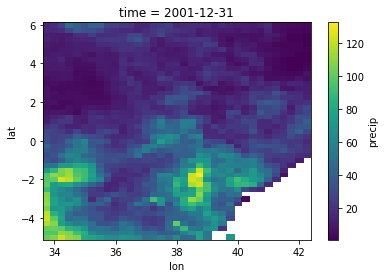

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT, safe=False)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT, safe=False)

X_train.precip.isel(time=0).plot()

In [6]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [7]:
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan

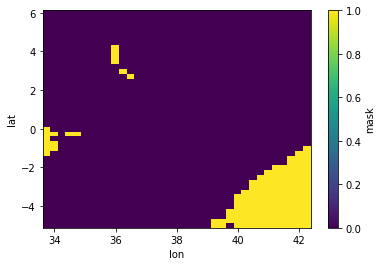

In [8]:
mask = get_ds_mask(X_train.VCI)
mask.plot()

In [9]:
ealstm_pred = read_pred_data(
    'ealstm', data_dir, experiment='one_month_forecast_predict_delta_norm_y_latlons'
).where(~mask)

Reading all .nc files from: data/models/one_month_forecast_predict_delta_norm_y_latlons/ealstm
All datasets loaded. Now combining ...


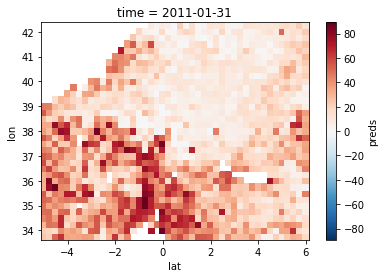

In [10]:
ealstm_pred.isel(time=0).preds.plot()

# Time Series of the Performance

In [11]:
from src.analysis import annual_scores

In [12]:
# load the monthly scores dictionary
experiment = 'one_month_forecast_predict_delta_norm_y_latlons'
true_data_experiment = 'one_month_forecast'
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['ealstm'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2016, 2019)],
    experiment=experiment,
    true_data_experiment=TRUE_EXPERIMENT,
    target_var=TARGET_VAR,
    verbose=False,
    to_dataframe=True
)
monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores.head()

,month,year,ealstm,metric,time
0,1.0,2016.0,25.227208,rmse,2016-01-01
1,2.0,2016.0,25.651496,rmse,2016-02-01
2,3.0,2016.0,27.508322,rmse,2016-03-01
3,4.0,2016.0,19.360611,rmse,2016-04-01
4,5.0,2016.0,22.350349,rmse,2016-05-01


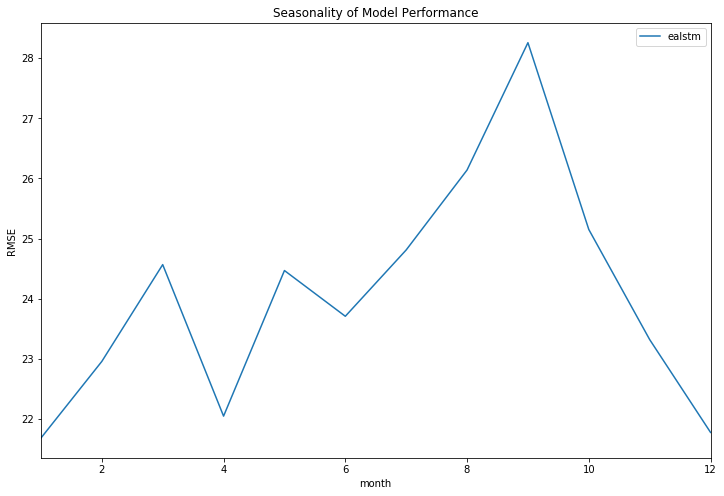

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['ealstm']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel('RMSE');

# (
#     monthly_scores
#     .where(monthly_scores.metric == 'rmse')
#     .groupby('month').mean().reset_index()
#     .plot(x='month', y=model, label=model, ax=ax)
# )

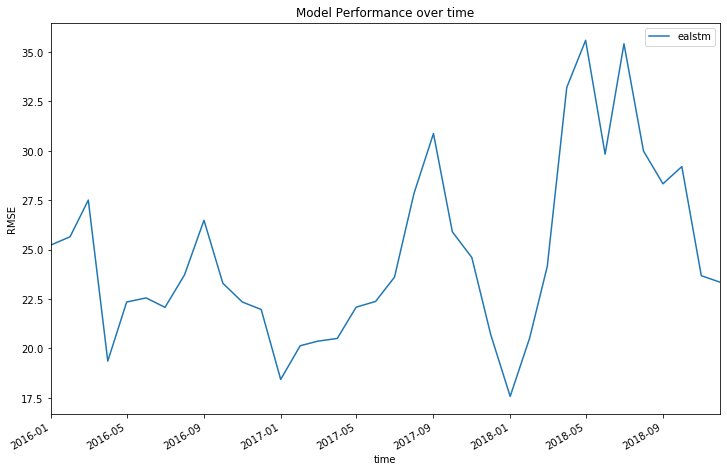

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['ealstm']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .set_index('time')
        .plot(y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Model Performance over time')
ax.set_ylabel('RMSE');

In [15]:
y_test

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 86.73 84.35 84.04 ... 11.94 78.34 40.51

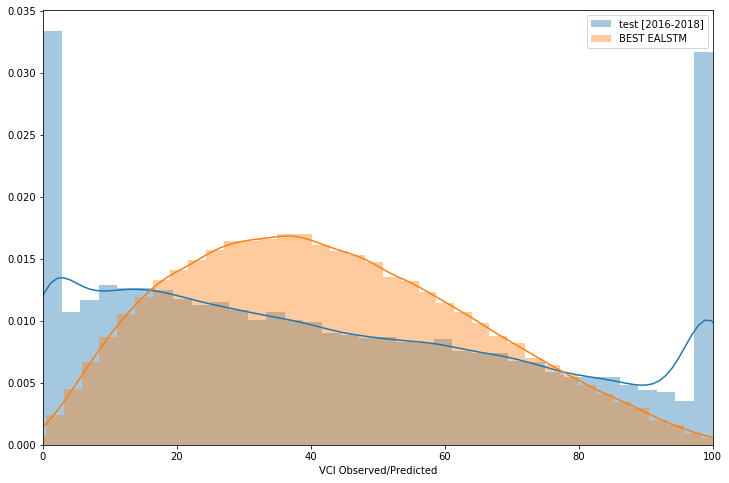

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test.boku_VCI), ax=ax, label='test [2016-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.VCI), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='Previous EALSTM')
sns.distplot(drop_nans_and_flatten(ealstm_pred.preds), ax=ax, label='BEST EALSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted');

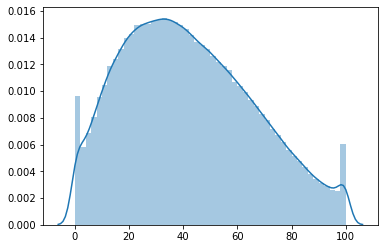

In [17]:
v = ds.VCI.values
sns.distplot(v[~np.isnan(v)])

(33.625, 42.375)
(-5.125, 6.125)


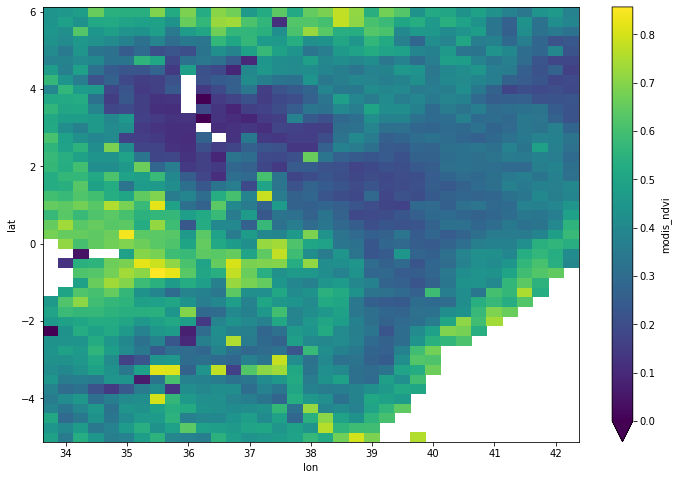

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ds.modis_ndvi.where(~mask).mean(dim='time').plot(ax=ax, vmin=0)

print(ax.get_xlim())
print(ax.get_ylim())

# Explore performance in different regions